In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.metrics import roc_curve, auc
from scipy.io.arff import loadarff 

# from tf.keras.models import Sequential  # This does not work!
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding,LSTM, CuDNNLSTM, Flatten, MaxPooling1D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, TimeDistributed, Conv1D, Conv2D
from tensorflow.python.keras.optimizers import adam
from tensorflow.python.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import matplotlib.pyplot as plt

from time import time

def draw_roc_keras(model,xt, yt):
    predictions = model.predict(xt)
    # for in in range(2):
    fpr, tpr, thr = roc_curve(yt, predictions) #[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format('keras'))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return predictions

In [3]:
train_path="Data/FordB_TRAIN.arff"
test_path="Data/FordB_TEST.arff"

def read_ariff(path):
    raw_data, meta =loadarff(path)
    cols=[x for x in meta]
    data2d=np.zeros([raw_data.shape[0],len(cols)])
    for i,col in zip(range(len(cols)),cols):
        data2d[:,i]=raw_data[col]
    print(data2d.shape)
    return data2d

data2d=read_ariff(train_path)
test2d=read_ariff(test_path)
print(data2d.shape, test2d.shape)


(3636, 501)
(810, 501)
(3636, 501) (810, 501)


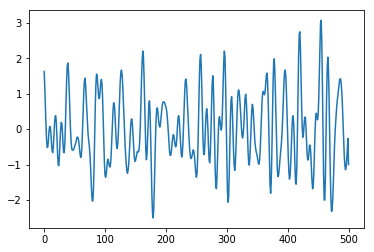

In [4]:
plt.plot(data2d[1,:])
plt.show()

Splitting into validation and training

In [5]:
failed=data2d[data2d[:,-1]==1]
not_failed=data2d[data2d[:,-1]==-1]
print(failed.shape, not_failed.shape)

train2d=np.concatenate((failed[:int(0.8*failed.shape[0])],
                       not_failed[:int(0.8*failed.shape[0])]),
                       axis=0)

val2d=np.concatenate((failed[int(0.8*failed.shape[0]):],
                       not_failed[int(0.8*failed.shape[0]):]),
                       axis=0)

np.random.shuffle(train2d)
np.random.shuffle(val2d)

print(train2d.shape, val2d.shape)

(1776, 501) (1860, 501)
(2840, 501) (796, 501)


Making 3d arrays

In [6]:
def make3d(data):
    df=data.copy()
    x,y=df.shape
    data3d=np.zeros([x,y-1,2])
    for i in range(x):
        data3d[i,:,0]=df[i][:-1].T
        data3d[i,:,1]=np.full((y-1),df[i][-1])
    return data3d

train3d=make3d(train2d)
val3d  =make3d(val2d)
test3d =make3d(test2d)
print(train3d.shape, val3d.shape, test3d.shape)

(2840, 500, 2) (796, 500, 2) (810, 500, 2)


Scaling the data

In [23]:
def scale_d(data):
    df=data.copy()
    df_scaled=np.zeros(df.shape)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    stder = StandardScaler()
    for i in range(df.shape[0]):
        df_scaled[i,:,0]=stder.fit_transform(
                                         df[i,:,0].reshape((df.shape[1], 1))
                                         ).reshape((df.shape[1]))
#         df_scaled[i,:,0]=scaler.fit_transform(
#                                          df[i,:,0].reshape((df.shape[1], 1))
#                                          ).reshape((df.shape[1]))
        df_scaled[i,:,1]=df[i,:,1]
    return df_scaled

train_scaled=scale_d(train3d)
val_scaled  =scale_d(val3d)
test_scaled =scale_d(test3d)

x_train  =np.expand_dims(train_scaled[:,:,0],axis=2)
y_train  =train_scaled[:,:,1]
y_train_e=np.expand_dims(y_train,axis=2)
y_train_s=y_train[:,0]
y_train_s=np.array([1. if x==1 else 0. for x in y_train[:,0]])


x_val   =np.expand_dims(val_scaled[:,:,0],axis=2)
y_val   =val_scaled[:,:,1]
y_val_e =np.expand_dims(y_val,axis=2)
y_val_s =y_val[:,0]
y_val_s=np.array([1. if x==1 else 0. for x in y_val[:,0]])


x_test  =np.expand_dims(test_scaled[:,:,0],axis=2)
y_test  =test_scaled[:,:,1]
y_test_e=np.expand_dims(y_test,axis=2)
y_test_s=y_test[:,0]
y_test_s=np.array([1. if x==1 else 0. for x in y_test[:,0]])

print(x_train.shape,x_val.shape,x_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)
print(y_train_e.shape,y_val_e.shape,y_test_e.shape)
print(y_train_s.shape,y_val_s.shape,y_test_s.shape)


(2840, 500, 1) (796, 500, 1) (810, 500, 1)
(2840, 500) (796, 500) (810, 500)
(2840, 500, 1) (796, 500, 1) (810, 500, 1)
(2840,) (796,) (810,)


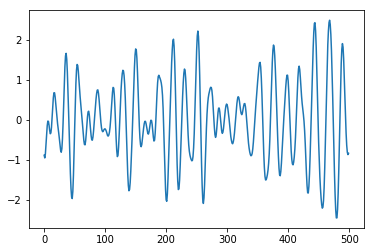

In [24]:
plt.plot(x_train[11,:,0])
plt.show()

Genereator function

In [25]:
def batch_generator(data_x,data_y,sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    df_x=data_x.copy()
    df_y=data_y.copy()
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (df_x.shape[0], sequence_length, df_x.shape[2])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (df_y.shape[0], sequence_length, df_y.shape[2])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(df_x.shape[0]):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(df_x.shape[1] - sequence_length)
#             print(idx,idx+sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = df_x[i,idx:idx+sequence_length,:]
            y_batch[i] = df_y[i,idx:idx+sequence_length,:]
        
        yield (x_batch, y_batch)
        
def batch_generator_s(data_x,data_y,sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    df_x=data_x.copy()
    df_y=data_y.copy()
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (df_x.shape[0], sequence_length, df_x.shape[2])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (df_y.shape[0], 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(df_x.shape[0]):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(df_x.shape[1] - sequence_length)
#             print(idx,idx+sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = df_x[i,idx:idx+sequence_length,:]
        y_batch = df_y
        
        yield (x_batch, y_batch)
        


In [26]:
gen_val=batch_generator(x_val,y_val_e,100)
x_batch,y_batch=next(gen_val)
print(x_batch.shape,y_batch.shape)

(796, 100, 1) (796, 100, 1)


Function to load best callback

In [27]:
class GetBest(Callback):
    """Get the best model at the end of training.
	# Arguments
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        mode: one of {auto, min, max}.
            The decision
            to overwrite the current stored weights is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
	# Example
		callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]
		mode.fit(X, y, validation_data=(X_eval, Y_eval),
                 callbacks=callbacks)
    """

    def __init__(self, monitor='val_loss', verbose=0,
                 mode='auto', period=1):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.period = period
        self.best_epochs = 0
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('GetBest mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf
                
    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            #filepath = self.filepath.format(epoch=epoch + 1, **logs)
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can pick best model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best):
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                              ' storing weights.'
                              % (epoch + 1, self.monitor, self.best,
                                 current))
                    self.best = current
                    self.best_epochs = epoch + 1
                    self.best_weights = self.model.get_weights()
                else:
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s did not improve' %
                              (epoch + 1, self.monitor))            
                    
    def on_train_end(self, logs=None):
        if self.verbose > 0:
            print('Using epoch %05d with %s: %0.5f' % (self.best_epochs, self.monitor,
                                                       self.best))
        self.model.set_weights(self.best_weights)

# Creating the model

## The Best Model

Epoch 1/60
 9/10 [==========================>...] - ETA: 0s - loss: 0.6858 - acc: 0.5584
Epoch 00001: val_acc improved from -inf to 0.69698, storing weights.
10/10 [==============================] - 7s 689ms/step - loss: 0.6826 - acc: 0.5810 - val_loss: 0.6673 - val_acc: 0.6970
Epoch 2/60
 9/10 [==========================>...] - ETA: 0s - loss: 0.5633 - acc: 0.7937
Epoch 00002: val_acc improved from 0.69698 to 0.78166, storing weights.
10/10 [==============================] - 5s 527ms/step - loss: 0.5687 - acc: 0.7836 - val_loss: 0.4820 - val_acc: 0.7817
Epoch 3/60
 9/10 [==========================>...] - ETA: 0s - loss: 0.3274 - acc: 0.8567
Epoch 00003: val_acc improved from 0.78166 to 0.83392, storing weights.
10/10 [==============================] - 5s 525ms/step - loss: 0.3196 - acc: 0.8625 - val_loss: 0.3534 - val_acc: 0.8339
Epoch 4/60
 9/10 [==========================>...] - ETA: 0s - loss: 0.2279 - acc: 0.9063
Epoch 00004: val_acc improved from 0.83392 to 0.87399, storing weigh

Epoch 33/60
 9/10 [==========================>...] - ETA: 0s - loss: 0.4954 - acc: 0.7466
Epoch 00033: val_acc did not improve
10/10 [==============================] - 5s 526ms/step - loss: 0.4893 - acc: 0.7528 - val_loss: 0.5809 - val_acc: 0.6798
Epoch 34/60
 9/10 [==========================>...] - ETA: 0s - loss: 0.3900 - acc: 0.8300
Epoch 00034: val_acc did not improve
10/10 [==============================] - 5s 526ms/step - loss: 0.3869 - acc: 0.8309 - val_loss: 0.5541 - val_acc: 0.7347
Epoch 35/60
 9/10 [==========================>...] - ETA: 0s - loss: 0.2894 - acc: 0.8729
Epoch 00035: val_acc did not improve
10/10 [==============================] - 5s 525ms/step - loss: 0.2844 - acc: 0.8755 - val_loss: 0.4345 - val_acc: 0.7765
Epoch 36/60
 9/10 [==========================>...] - ETA: 0s - loss: 0.2299 - acc: 0.9043
Epoch 00036: val_acc did not improve
10/10 [==============================] - 5s 525ms/step - loss: 0.2279 - acc: 0.9057 - val_loss: 0.3208 - val_acc: 0.8678
Epoch 37

acc: 79.63%


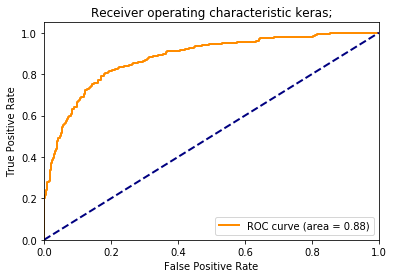

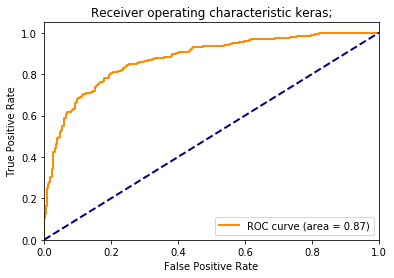

acc: 79.63%


In [28]:
seq_len=350
STEPS = 10
EPOCHS= 60

NAME = f"fordB-{seq_len}seq_{int(time())}"
model_d = Sequential()


# model_d.add(BatchNormalization(input_shape=(seq_len,1)))
model_d.add(CuDNNLSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,1)))

model_d.add(Conv1D(filters=100, 
                   kernel_size=20, 
                   activation='relu',
                   data_format="channels_last",
                   input_shape=(seq_len,1)
                  ))
# model_d.add()
model_d.add(Conv1D(filters=100, 
                   kernel_size=10, 
                   activation='relu',
                   data_format="channels_last",
                   input_shape=(seq_len,1)
                  ))
model_d.add(Conv1D(filters=100, 
                   kernel_size=5, 
                   activation='relu',
                   data_format="channels_last",
                   input_shape=(seq_len,1)
                  ))
model_d.add(Conv1D(filters=100, 
                   kernel_size=3, 
                   activation='relu',
                   data_format="channels_last",
                   input_shape=(seq_len,1)
                  ))

# model_d.add(Dropout(0.5))
# model_d.add(TimeDistributed(Dense(100, activation='relu')))

model_d.add(Flatten())
# model_d.add(Dropout(0.5))
# model_d.add(Dense(100, activation='relu'))
# model_d.add(Dense(100, activation='relu'))

# model_d.add(Dropout(0.5))
model_d.add(Dense(1, activation='sigmoid'))


model_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


gen_train=batch_generator_s(x_train,y_train_s,seq_len)

gen_val  =batch_generator_s(x_val,y_val_s,seq_len)

tensorboard=TensorBoard(log_dir='Logs/{}'.format(NAME))

checkp=ModelCheckpoint('model_ds/best.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

best=GetBest(monitor='val_acc', verbose=1, mode='max')

callbacks=[best, tensorboard]

model_d.fit_generator(generator=gen_train,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS,
                    validation_data =gen_val,
                    validation_steps =STEPS,
                    callbacks=callbacks
                   )
model_d.summary()

scores = model_d.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)

print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))
pred=draw_roc_keras(model_d,[x_test[:,:seq_len,:]],y_test_s)
pred=draw_roc_keras(model_d,[x_test[:,-seq_len:,:]],y_test_s)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))

## Second Best Model Just LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 350, 100)          41200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 35000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3500100   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,541,401
Trainable params: 3,541,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
49/50 [============================>.] - ETA: 0s - loss: 0.4202 - acc: 0.8022
Epoch 00001: val_acc improved from -inf to 0.82106, storing weights.
50/50 [==============================] - 9s 188ms/step - loss: 0.4182 - acc: 0.8035 - val_loss: 0.4126 - v

Epoch 29/60
49/50 [============================>.] - ETA: 0s - loss: 0.0601 - acc: 0.9782
Epoch 00029: val_acc did not improve
50/50 [==============================] - 8s 166ms/step - loss: 0.0600 - acc: 0.9782 - val_loss: 0.3619 - val_acc: 0.8839
Epoch 30/60
49/50 [============================>.] - ETA: 0s - loss: 0.0567 - acc: 0.9795
Epoch 00030: val_acc did not improve
50/50 [==============================] - 8s 166ms/step - loss: 0.0566 - acc: 0.9795 - val_loss: 0.3682 - val_acc: 0.8841
Epoch 31/60
49/50 [============================>.] - ETA: 0s - loss: 0.0520 - acc: 0.9815
Epoch 00031: val_acc did not improve
50/50 [==============================] - 8s 165ms/step - loss: 0.0518 - acc: 0.9816 - val_loss: 0.3794 - val_acc: 0.8849
Epoch 32/60
49/50 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9819
Epoch 00032: val_acc did not improve
50/50 [==============================] - 8s 166ms/step - loss: 0.0501 - acc: 0.9819 - val_loss: 0.3887 - val_acc: 0.8828
Epoch 33

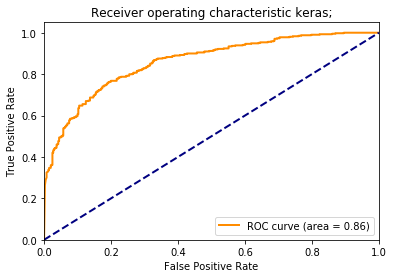

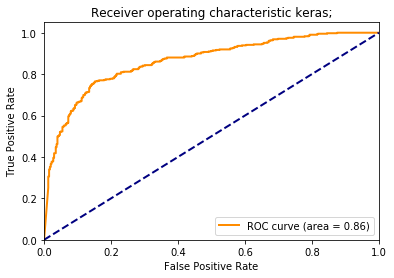

acc: 79.51%


In [14]:
seq_len=350
STEPS = 50
EPOCHS= 60

NAME = f"td_fordB-{seq_len}seq_{int(time())}"
model_d = Sequential()


# model_d.add(BatchNormalization(input_shape=(seq_len,1)))
model_d.add(CuDNNLSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,1)))

# model_d.add(Dropout(0.5))
# model_d.add(TimeDistributed(Dense(100, activation='relu')))

model_d.add(Flatten())
# model_d.add(Dropout(0.5))
model_d.add(Dense(100, activation='relu'))
# model_d.add(Dense(100, activation='relu'))

# model_d.add(Dropout(0.5))
model_d.add(Dense(1, activation='sigmoid'))


model_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_d.summary()


gen_train=batch_generator_s(x_train,y_train_s,seq_len)

gen_val  =batch_generator_s(x_val,y_val_s,seq_len)

tensorboard=TensorBoard(log_dir='Logs/{}'.format(NAME))

checkp=ModelCheckpoint('model_ds/best.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

best=GetBest(monitor='val_acc', verbose=1, mode='max')

callbacks=[best, tensorboard]

model_d.fit_generator(generator=gen_train,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS,
                    validation_data =gen_val,
                    validation_steps =STEPS,
                    callbacks=callbacks
                   )


scores = model_d.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))
pred=draw_roc_keras(model_d,[x_test[:,:seq_len,:]],y_test_s)
pred=draw_roc_keras(model_d,[x_test[:,-seq_len:,:]],y_test_s)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))

acc: 79.51%


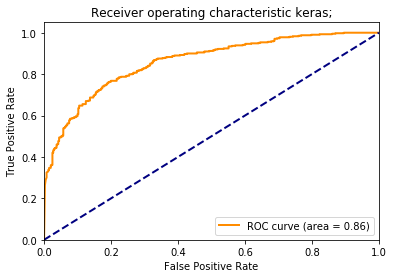

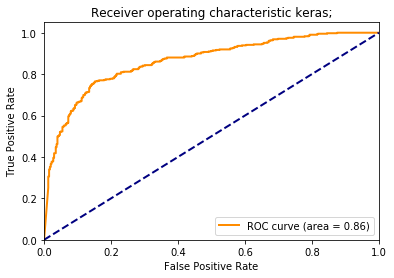

acc: 79.51%


In [15]:
scores = model_d.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)

print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))
pred=draw_roc_keras(model_d,[x_test[:,:seq_len,:]],y_test_s)
pred=draw_roc_keras(model_d,[x_test[:,-seq_len:,:]],y_test_s)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))

In [16]:
gen_test =batch_generator_s(x_test,y_test_s,seq_len)
for i in range(100):
    x_batch, y_batch= next(gen_test)
    scores = model_d.evaluate([x_batch], y_batch, verbose=0)
    print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))
#     pred=draw_roc_keras(model_d,[x_batch],y_batch)


acc: 77.90%
acc: 77.90%
acc: 79.26%
acc: 79.88%
acc: 78.02%
acc: 77.65%
acc: 77.41%
acc: 79.75%
acc: 77.90%
acc: 78.15%
acc: 78.52%
acc: 77.78%
acc: 80.12%
acc: 77.65%
acc: 78.40%
acc: 79.38%
acc: 79.14%
acc: 77.53%
acc: 78.52%
acc: 78.89%
acc: 77.53%
acc: 79.51%
acc: 79.75%
acc: 79.51%
acc: 78.77%
acc: 78.52%
acc: 78.15%
acc: 79.26%
acc: 78.15%
acc: 78.27%
acc: 77.78%
acc: 77.78%
acc: 78.52%
acc: 77.78%
acc: 78.52%
acc: 78.15%
acc: 78.40%
acc: 77.90%
acc: 79.14%
acc: 78.77%
acc: 78.27%
acc: 78.77%
acc: 77.90%
acc: 79.75%
acc: 78.15%
acc: 76.91%
acc: 77.78%
acc: 79.26%
acc: 78.15%
acc: 77.28%
acc: 80.74%
acc: 78.02%
acc: 77.65%
acc: 79.75%
acc: 79.51%
acc: 79.75%
acc: 78.02%
acc: 77.53%
acc: 77.28%
acc: 78.52%
acc: 76.54%
acc: 77.41%
acc: 79.01%
acc: 79.01%
acc: 77.04%
acc: 77.16%
acc: 78.27%
acc: 78.89%
acc: 78.89%
acc: 78.77%
acc: 78.27%
acc: 78.40%
acc: 78.27%
acc: 77.04%
acc: 79.38%
acc: 78.52%
acc: 76.05%
acc: 79.63%
acc: 77.53%
acc: 78.27%
acc: 78.02%
acc: 77.65%
acc: 77.41%
acc:

In [ ]:
# # load weights
# model.load_weights("Models/best.hdf5")
# # Compile model (required to make predictions)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print("Created model and loaded weights from file")
# # load pima indians dataset
# # # estimate accuracy on whole dataset using loaded weights
# # scores = model.evaluate(X, Y, verbose=0)
# # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# pred=draw_roc_keras(model,[x_test[:,-seq_len:,:]],y_test_s)


#### Experimenting

In [ ]:
seq_len=350
STEPS = 20
EPOCHS= 60

NAME = f"conv1d_fordB-{seq_len}seq_{int(time())}"
model_d = Sequential()


# model_d.add(BatchNormalization(input_shape=(seq_len,1)))
model_d.add(CuDNNLSTM(units=100,
              return_sequences=True,
              input_shape=(seq_len,1)))

model_d.add(Conv1D(filters=100, 
                   kernel_size=100, 
                   activation='relu',
                   data_format="channels_last",
                   input_shape=(seq_len,1)
                  ))

model_d.add(Conv1D(filters=100, 
                   kernel_size=20, 
                   activation='relu',
                   data_format="channels_last",
                   input_shape=(seq_len,1)
                  ))
# model_d.add()
model_d.add(Conv1D(filters=100, 
                   kernel_size=10, 
                   activation='relu',
                   data_format="channels_last",
                   input_shape=(seq_len,1)
                  ))
model_d.add(Conv1D(filters=100, 
                   kernel_size=5, 
                   activation='relu',
                   data_format="channels_last",
                   input_shape=(seq_len,1)
                  ))
model_d.add(Conv1D(filters=100, 
                   kernel_size=3, 
                   activation='relu',
                   data_format="channels_last",
                   input_shape=(seq_len,1)
                  ))

model_d.add(Flatten())

model_d.add(Dense(1, activation='sigmoid'))

model_d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


gen_train=batch_generator_s(x_train,y_train_s,seq_len)

gen_val  =batch_generator_s(x_val,y_val_s,seq_len)

tensorboard=TensorBoard(log_dir='Logs/{}'.format(NAME))

checkp=ModelCheckpoint('model_ds/best.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

best=GetBest(monitor='val_acc', verbose=1, mode='max')

callbacks=[best, tensorboard]

model_d.fit_generator(generator=gen_train,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS,
                    validation_data =gen_val,
                    validation_steps =STEPS,
                    callbacks=callbacks
                   )
model_d.summary()

scores = model_d.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)

print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))
pred=draw_roc_keras(model_d,[x_test[:,:seq_len,:]],y_test_s)
pred=draw_roc_keras(model_d,[x_test[:,-seq_len:,:]],y_test_s)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))

In [ ]:
scores = model_d.evaluate([x_test[:,-seq_len:,:]], y_test_s, verbose=0)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))
pred=draw_roc_keras(model_d,[x_test[:,:seq_len,:]],y_test_s)
pred=draw_roc_keras(model_d,[x_test[:,-seq_len:,:]],y_test_s)
print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))

In [ ]:
gen_test =batch_generator_s(x_test,y_test_s,seq_len)
for i in range(100):
    x_batch, y_batch= next(gen_test)
    scores = model_d.evaluate([x_batch], y_batch, verbose=0)
    print("%s: %.2f%%" % (model_d.metrics_names[1], scores[1]*100))
#     pred=draw_roc_keras(model_d,[x_batch],y_batch)


In [ ]:
pred=model_d.predict_generator(gen_test, steps=10, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
print(pred.shape)
pred